<a href="https://colab.research.google.com/github/KevinCantrell/Polychromatic/blob/master/LEDModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter.filedialog import askopenfilename
from scipy.signal import savgol_filter
from scipy.stats import norm

import io
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
 
dfOOSpec=pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
list(dfOOSpec)

Saving LEDData.csv to LEDData (2).csv
User uploaded file "LEDData.csv" with length 49453 bytes


['nm', 'abs', 'blue', 'bluegreen', 'green', 'orange', 'white', 'yellow', 'red']

In [6]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
 

XLFileDF = pd.read_excel(io.StringIO(uploaded[fn].decode('utf-8')),skiprows=63)
list(XLFileDF)

Saving all_1nm_data.xls to all_1nm_data.xls
User uploaded file "all_1nm_data.xls" with length 120320 bytes


UnicodeDecodeError: ignored

In [0]:
XYZtolRGB=np.array([[3.2406255,-1.537208,-0.4986286],[-0.9689307,1.8757561,0.0415175],[0.0557101,-0.2040211,1.0569959]])

def  XYZtransferLAB(t):
    if t>(6/29.0)**3:
        return(t**(1/3.0))
    else:
        return(((1/3.0*(29/6.0)**2)*t)+4/29.0)
    
def interpolateResponse(OOWaves, CIEWaves, X):
    numCIEwaves=CIEWaves.shape[0]
    Xind=np.zeros((numCIEwaves+int(np.floor(OOWaves[0]))))
    for index in range(numCIEwaves):
        newindex=int(CIEWaves[index])
        Xind[newindex]=X[index]
    numOOwaves=OOWaves.shape[0]
    Xout=np.zeros((numOOwaves))
    for i in range(numOOwaves):
        roundedlow=int(np.floor(OOWaves[i]))
        roundedhigh=roundedlow+1
        if roundedhigh<CIEWaves[numCIEwaves-1]:
            Xout[i]=((Xind[roundedhigh]-Xind[roundedlow])*(OOWaves[i]-roundedlow))+Xind[roundedlow]
    return (Xout)

def sourceToRGB(source,OOwaves):
    XLFileDF = pd.read_excel('all_1nm_data.xls',skiprows=63)
    CIEX=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,5])
    CIEY=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,6])
    CIEZ=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,7])
    maxSource=np.zeros((source.shape))
    maxSource[:]=np.max(source)
    Yr=np.trapz(CIEY*maxSource, OOwaves)
    X=np.trapz(CIEX*source, OOwaves)/Yr
    Y=np.trapz(CIEY*source, OOwaves)/Yr
    Z=np.trapz(CIEZ*source, OOwaves)/Yr
    RGBl=np.dot(XYZtolRGB,[X,Y,Z])
    RGBg=np.zeros((RGBl.shape))
    for cc in range(RGBl.shape[0]):
        if RGBl[cc]<=0.0031308:
            RGBg[cc]=12.92*RGBl[cc]
        else:
            RGBg[cc]=1.055*RGBl[cc]**(1/2.4)-0.055
        #RGBs[cc]=int(round(RGBg[cc]*255.0))
        if RGBg[cc]>1:
            RGBg[cc]=1
        elif RGBg[cc]<0:
            RGBg[cc]=0
    return RGBg

def absorbanceToRGB(absorbance,OOwaves):
#    XLFileDF = pd.read_excel('C:\Users\Kevin\Dropbox\Python\\all_1nm_data.xls',skiprows=63)
    XLFileDF = pd.read_excel('all_1nm_data.xls',skiprows=63)
    CIEX=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,5])
    CIEY=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,6])
    CIEZ=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,7])
    D65=interpolateResponse(OOwaves, XLFileDF.values[:,0],XLFileDF.values[:,2])
    #Xr=np.trapz(CIEX*D65, OOwaves)
    Yr=np.trapz(CIEY*D65, OOwaves)
    #Zr=np.trapz(CIEZ*D65, OOwaves)
    X=np.trapz(CIEX*D65*10**-absorbance, OOwaves)/Yr
    Y=np.trapz(CIEY*D65*10**-absorbance, OOwaves)/Yr
    Z=np.trapz(CIEZ*D65*10**-absorbance, OOwaves)/Yr
    RGBl=np.dot(XYZtolRGB,[X,Y,Z])
    RGBg=np.zeros((RGBl.shape))
    #RGBs=np.zeros((RGBl.shape))
    for cc in range(RGBl.shape[0]):
        if RGBl[cc]<=0.0031308:
            RGBg[cc]=12.92*RGBl[cc]
        else:
            RGBg[cc]=1.055*RGBl[cc]**(1/2.4)-0.055
        #RGBs[cc]=int(round(RGBg[cc]*255.0))
        if RGBg[cc]>1:
            RGBg[cc]=1
        elif RGBg[cc]<0:
            RGBg[cc]=0
    return RGBg

def smoothAndAverage(oldX,oldY,startnm,endnm,stepnm):
    stepnm=1
    startnm=400
    endnm=700
    smoothY=savgol_filter(oldY, 13, 2)
    newX=np.arange(startnm,endnm,stepnm)
    newY=np.zeros((newX.shape))
    index=0
    for wavelength in newX:
        oldXBool=(oldX >= (wavelength-(stepnm/2.0))) & (oldX <= (wavelength+(stepnm/2.0)))
        newY[index]=np.average((smoothY[oldXBool]))
        index=index+1
    return newX,newY

def CalcConc(S,fit):
    roots=np.roots(fit['poly']-S)
    return roots

def PolyReg(X,Y,order):
    coef,cov=np.polyfit(X,Y,order,cov=True)
    N=float(len(X))
    df=N-len(coef)
    stdErrors=np.sqrt(np.diagonal(cov)*(df-2)/df)
    p=np.poly1d(coef)
    yfit=p(X)
    res=Y-yfit
    sy=np.sqrt( np.sum(res**2) / df )
    return {'coef':coef,'errors':stdErrors,'n':N,'sy':sy,'res':res,'poly':p}

def FormatSciUsingError(x,e,WithError=False,ExtraDigit=0):
    if abs(x)>=e:
        NonZeroErrorX=np.floor(np.log10(abs(e)))
        NonZeroX=np.floor(np.log10(abs(x)))
        formatCodeX="{0:."+str(int(NonZeroX-NonZeroErrorX+ExtraDigit))+"E}"
        formatCodeE="{0:."+str(ExtraDigit)+"E}"
    else:
        formatCodeX="{0:."+str(ExtraDigit)+"E}"
        formatCodeE="{0:."+str(ExtraDigit)+"E}"
    if WithError==True:
        return formatCodeX.format(x)+" (+/- "+formatCodeE.format(e)+")"
    else:
        return formatCodeX.format(x) 

def AnnotateFit(fit,axisHandle,annotationText='Eq',color='black',Arrow=False,xArrow=0,yArrow=0,xText=0.5,yText=0.2):
    c=fit['coef']
    e=fit['errors']
    t=len(c)
    if annotationText=='Eq':
        annotationText="y = "
        for order in range(t):
            exponent=t-order-1
            if exponent>=2:
                annotationText=annotationText+FormatSciUsingError(c[order],e[order])+"x$^{}$".format(exponent)+" + "
            elif exponent==1:
                annotationText=annotationText+FormatSciUsingError(c[order],e[order])+"x + "
            else:
                annotationText=annotationText+FormatSciUsingError(c[order],e[order])
        annotationText=annotationText+", sy={0:.1E}".format(fit['sy'])
    if (Arrow==True):
        if (xArrow==0):
            xSpan=axisHandle.get_xlim()
            xArrow=np.mean(xSpan)
        if (yArrow==0):    
            yArrow=fit['poly'](xArrow)
        annotationObject=axisHandle.annotate(annotationText, 
                xy=(xArrow, yArrow), xycoords='data',
                xytext=(xText, yText),  textcoords='axes fraction',
                arrowprops={'color': color, 'width':1, 'headwidth':5},
                bbox={'boxstyle':'round', 'edgecolor':color,'facecolor':'0.8'}
                )
    else:
        xSpan=axisHandle.get_xlim()
        xArrow=np.mean(xSpan)
        ySpan=axisHandle.get_ylim()
        yArrow=np.mean(ySpan)
        annotationObject=axisHandle.annotate(annotationText, 
                xy=(xArrow, yArrow), xycoords='data',
                xytext=(xText, yText),  textcoords='axes fraction',
                ha="left", va="center",
                bbox={'boxstyle':'round', 'edgecolor':color,'facecolor':'0.8'}
                )
    annotationObject.draggable()

FileNotFoundError: ignored

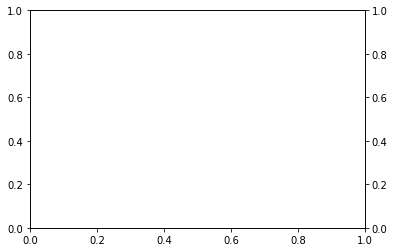

In [5]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
OOwaves=dfOOSpec.iloc[:, 0]
absorptivity=dfOOSpec.iloc[:, 1]
absorptivity=np.array(absorptivity)
OOwaves=np.array(OOwaves)

waves,absorptivity=smoothAndAverage(OOwaves,absorptivity,400,700,1)
abs1_5conc=1.5/np.max(absorptivity)
sampleColor=absorbanceToRGB(absorptivity*abs1_5conc,waves)
ax1.plot(waves,absorptivity*abs1_5conc,'-',color=sampleColor)

In [0]:
root = tk.Tk()
root.withdraw()
file_path = askopenfilename()
dfOOSpec=pd.read_csv(file_path)
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig2, ax = plt.subplots()
ax = plt.subplot()

OOwaves=dfOOSpec.iloc[:, 0]
absorptivity=dfOOSpec.iloc[:, 1]
absorptivity=np.array(absorptivity)
OOwaves=np.array(OOwaves)

waves,absorptivity=smoothAndAverage(OOwaves,absorptivity,400,700,1)
abs1_5conc=1.5/np.max(absorptivity)
sampleColor=absorbanceToRGB(absorptivity*abs1_5conc,waves)
ax1.plot(waves,absorptivity*abs1_5conc,'-',color=sampleColor)

LEDmean=np.arange(400,700,30)
standard_deviation = 15
sourceColor=np.zeros((len(LEDmean),3))
sourceCoefs=np.zeros((len(LEDmean),3))
concList=np.arange(0,abs1_5conc,abs1_5conc/100)
sourceIndex=0
fitResults={}
for sourceCenter in LEDmean:
    source=norm.pdf(waves, sourceCenter, standard_deviation)
    sourceColor[sourceIndex,:]=sourceToRGB(source,waves)
    ax2.plot(waves,source,'-',color=sourceColor[sourceIndex,:],label=str(sourceCenter))  
    monoAbs=np.zeros((len(LEDmean),len(concList)))
    polyAbs=np.zeros((len(LEDmean),len(concList)))
    P0=np.trapz(source, waves)
    path=1
    concIndex=0
    for conc in concList:
        sampleAbsorbance=absorptivity*conc*path
        transmittance=10**-(sampleAbsorbance)
        attenuatedSource=source*transmittance
        P=np.trapz(attenuatedSource, waves)
        #ax2.plot(waves,attenuatedSource,':',color=sourceColor)
        monoAbs[sourceIndex,concIndex]=np.max(sampleAbsorbance)
        polyAbs[sourceIndex,concIndex]=-np.log10(float(P)/P0)
        concIndex=concIndex+1
    ax.plot(concList,polyAbs[sourceIndex,:],'o',color=sourceColor[sourceIndex,:],label=str(sourceCenter))
    ax.plot(concList,monoAbs[sourceIndex,:],'-k')
    fit=PolyReg(concList,polyAbs[sourceIndex,:],2)
    sourceCoefs[sourceIndex,:]=np.array(fit['coef'])
    ax.plot(concList,fit['poly'](concList),'-',color=sourceColor[sourceIndex,:])
    fitResults[str(sourceCenter)]=fit
    sourceIndex=sourceIndex+1
leg=ax.legend()
#leg.draggable()

fig3, axS = plt.subplots()
axS = plt.subplot()    
sourceIndex=0
for sourceCenter in LEDmean:
    axS.plot(concList,sourceCoefs[sourceIndex,0]*2*concList+sourceCoefs[sourceIndex,1],color=sourceColor[sourceIndex,:],label=str(sourceCenter))
    sourceIndex=sourceIndex+1
leg=axS.legend()
#leg.draggable()

fig4, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(LEDmean,sourceCoefs[:,0],'r')
ax2.plot(LEDmean,sourceCoefs[:,1],'b')

fig5, ax1 = plt.subplots()
ax1.plot(LEDmean,sourceCoefs[:,0]*2*abs1_5conc+sourceCoefs[:,1],'b',label='absorptivity at c='+str(abs1_5conc))
ax1.plot(LEDmean,sourceCoefs[:,1],'r',label='initial absorptivity')
ax1.plot(waves,absorptivity,color=sampleColor,label='monochromatic absorptivity')
leg=ax1.legend()